# **Data Processing & EDA**

By: Aditya Mengani, Ognjen Sosa, Sanjay Elangovan, Song Park, Sophia Skowronski

## Import Libraries

In [435]:
# Import data analysis packages
import numpy as np
import pandas as pd
import csv
import warnings
import os
import time
import math
warnings.filterwarnings('ignore')

# Import plotting packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale=1.3)
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
from matplotlib.backends.backend_pdf import PdfPages

## Memory Reduction Function

In [436]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## **Load Data**

In [437]:
# Pledge 1% Company UUIDs

print('='*100)
p1 = pd.read_csv('files/p1.csv')
print('PLEDGE 1%/p1 cols: {}\nSHAPE: {}'.format(p1.columns.to_list(), p1.shape))

# Organizations 

print('='*100)
org = pd.read_csv('files/csv/organizations.csv')
print('ORGANIZATION/org cols: {}\nSHAPE: {}'.format(org.columns.to_list(), org.shape))

# People 

print('='*100)
ppl = pd.read_csv('files/csv/people.csv')
print('PEOPLE/ppl cols: {}\nSHAPE: {}'.format(ppl.columns.to_list(), ppl.shape))

# Financial 

print('='*100)
invest = pd.read_csv('files/csv/investments.csv')
print('\nINVESTMENTS/invest cols: {}\nSHAPE: {}'.format(invest.columns.to_list(), invest.shape))

investor = pd.read_csv('files/csv/investors.csv')
print('\nINVESTORS/investor cols: {}\nSHAPE: {}'.format(investor.columns.to_list(), investor.shape))

invest_prtnr = pd.read_csv('files/csv/investment_partners.csv')
print('\nPARTNER INVESTMENTS/invest_prtnr cols: {}\nSHAPE: {}'.format(invest_prtnr.columns.to_list(), invest_prtnr.shape))

fund_rnds = pd.read_csv('files/csv/funding_rounds.csv')
print('\nFUNDING ROUNDS/fund_rnds cols: {}\nSHAPE: {}'.format(fund_rnds.columns.to_list(), fund_rnds.shape))

# Jobs & Education

print('='*100)
jobs = pd.read_csv('files/csv/jobs.csv')
print('\nJOBS/jobs cols: {}\nSHAPE: {}'.format(jobs.columns.to_list(), jobs.shape))

educ = pd.read_csv('files/csv/degrees.csv')
print('\nEDUCATION/educ cols: {}\nSHAPE: {}'.format(educ.columns.to_list(), educ.shape))

print('='*100)


PLEDGE 1%/p1 cols: ['uuid', 'p1_tag', 'p1_date']
SHAPE: (7822, 3)
ORGANIZATION/org cols: ['uuid', 'name', 'type', 'permalink', 'cb_url', 'rank', 'created_at', 'updated_at', 'legal_name', 'roles', 'domain', 'homepage_url', 'country_code', 'state_code', 'region', 'city', 'address', 'postal_code', 'status', 'short_description', 'category_list', 'category_groups_list', 'num_funding_rounds', 'total_funding_usd', 'total_funding', 'total_funding_currency_code', 'founded_on', 'last_funding_on', 'closed_on', 'employee_count', 'email', 'phone', 'facebook_url', 'linkedin_url', 'twitter_url', 'logo_url', 'alias1', 'alias2', 'alias3', 'primary_role', 'num_exits']
SHAPE: (1131310, 41)
PEOPLE/ppl cols: ['uuid', 'name', 'type', 'permalink', 'cb_url', 'rank', 'created_at', 'updated_at', 'first_name', 'last_name', 'gender', 'country_code', 'state_code', 'region', 'city', 'featured_job_organization_uuid', 'featured_job_organization_name', 'featured_job_title', 'facebook_url', 'linkedin_url', 'twitter_url

In [438]:
# Update dataframe columns

org = org[['uuid', 'name', 'type', 'rank', 'roles', 'country_code', 'region', 'status', 
           'category_groups_list', 'total_funding_usd', 'founded_on', 'closed_on',
           'employee_count', 'primary_role']]

invest = invest[['uuid', 'funding_round_uuid', 'investor_uuid', 'investor_name', 'investor_type', 
                 'is_lead_investor']]

investor = investor[['uuid', 'name', 'investor_types']]

invest_prtnr = invest_prtnr[['uuid', 'funding_round_uuid', 'investor_uuid', 'investor_name', 
                             'partner_uuid', 'partner_name']]

fund_rnds['lead_investor_count']=fund_rnds['lead_investor_uuids'].str.split(',').apply(lambda x: float(len(x)) if ~np.any(pd.isnull(x)) else 0)
fund_rnds = fund_rnds[['uuid', 'investment_type', 'announced_on', 'raised_amount_usd', 
                       'post_money_valuation_usd', 'investor_count','lead_investor_uuids',
                       'lead_investor_count', 'org_uuid', 'org_name']]

jobs = jobs[['uuid', 'person_uuid', 'person_name', 'org_uuid', 'org_name', 'started_on', 'ended_on', 'is_current', 'title', 'job_type']]

educ = educ[['uuid', 'person_uuid', 'person_name', 'institution_uuid', 'institution_name', 'degree_type']]

p1.head(2)

,uuid,p1_tag,p1_date
0,beadb218-e5fa-2686-bc95-4dfaa9acc2e8,True,9/24/2015
1,cfe3ce79-49e0-77e4-7d45-7c75b902ef04,True,2/23/2016


In [439]:
org.head(2)

,uuid,name,type,rank,roles,country_code,region,status,category_groups_list,total_funding_usd,founded_on,closed_on,employee_count,primary_role
0,e1393508-30ea-8a36-3f96-dd3226033abd,Wetpaint,organization,102736.0,company,USA,New York,acquired,"Content and Publishing,Internet Services,Media...",39750000.0,2005-06-01,NaN,51-100,company
1,bf4d7b0e-b34d-2fd8-d292-6049c4f7efc7,Zoho,organization,24985.0,"investor,company",USA,California,operating,"Information Technology,Internet Services,Priva...",NaN,1996-09-15,NaN,1001-5000,company


In [440]:
fund_rnds.head(5)

,uuid,investment_type,announced_on,raised_amount_usd,post_money_valuation_usd,investor_count,lead_investor_uuids,lead_investor_count,org_uuid,org_name
0,8a945939-18e0-cc9d-27b9-bf33817b2818,angel,2004-09-01,500000.0,NaN,4.0,3f47be49-2e32-8118-01a0-31685a4d0fd7,1.0,df662812-7f97-0b43-9d3e-12f64f504fbb,Facebook
1,d950d7a5-79ff-fb93-ca87-13386b0e2feb,series_a,2005-05-01,12700000.0,98000000.0,4.0,b08efc27-da40-505a-6f9d-c9e14247bf36,1.0,df662812-7f97-0b43-9d3e-12f64f504fbb,Facebook
2,6fae3958-a001-27c0-fb7e-666266aedd78,series_b,2006-04-01,27500000.0,502500000.0,5.0,"e2006571-6b7a-e477-002a-f7014f48a7e3,8d5c7e48-...",2.0,df662812-7f97-0b43-9d3e-12f64f504fbb,Facebook
3,bcd5a63d-ed99-6963-0dd2-e36f6582f846,series_b,2006-05-01,10500000.0,NaN,2.0,NaN,0.0,f53cb4de-236e-0b1b-dee8-7104a8b018f9,Photobucket
4,60e6afd9-1215-465a-dd17-0ed600d4e29b,series_a,2007-01-17,NaN,10000000.0,1.0,fb2f8884-ec07-895a-48d7-d9a9d4d7175c,1.0,4111dc8b-c0df-2d24-ed33-30cd137b3098,Geni


In [441]:
invest.head(5)

,uuid,funding_round_uuid,investor_uuid,investor_name,investor_type,is_lead_investor
0,524986f0-3049-54a4-fa72-f60897a5e61d,d950d7a5-79ff-fb93-ca87-13386b0e2feb,b08efc27-da40-505a-6f9d-c9e14247bf36,Accel,organization,True
1,6556ab92-6465-25aa-1ffc-7f8b4b09a476,6fae3958-a001-27c0-fb7e-666266aedd78,e2006571-6b7a-e477-002a-f7014f48a7e3,Greylock,organization,True
2,0216e06a-61f8-9cf1-19ba-20811229c53e,6fae3958-a001-27c0-fb7e-666266aedd78,8d5c7e48-82da-3025-dd46-346a31bab86f,Meritech Capital Partners,organization,True
3,dadd7d86-520d-5e35-3033-fc1d8792ab91,bcd5a63d-ed99-6963-0dd2-e36f6582f846,7ca12f7a-2f8e-48b4-a8d1-1a33a0e275b9,Trinity Ventures,organization,NaN
4,581c4b38-9653-7117-9bd4-7ffe5c7eba69,60e6afd9-1215-465a-dd17-0ed600d4e29b,fb2f8884-ec07-895a-48d7-d9a9d4d7175c,Founders Fund,organization,True


In [442]:
investor.head(5)

,uuid,name,investor_types
0,bf4d7b0e-b34d-2fd8-d292-6049c4f7efc7,Zoho,NaN
1,f4d5ab44-058b-298b-ea81-380e6e9a8eec,Omidyar Network,family_investment_office
2,df662812-7f97-0b43-9d3e-12f64f504fbb,Facebook,NaN
3,a01b8d46-d311-3333-7c34-aa3ae9c03f22,Mark Zuckerberg,angel
4,084aaa07-0795-1fe8-9c46-98bbeb02cd64,Dustin Moskovitz,angel


In [443]:
invest_prtnr.head(2)

,uuid,funding_round_uuid,investor_uuid,investor_name,partner_uuid,partner_name
0,524986f0-3049-54a4-fa72-f60897a5e61d,d950d7a5-79ff-fb93-ca87-13386b0e2feb,b08efc27-da40-505a-6f9d-c9e14247bf36,Accel,2d78d1e7-203c-3eb6-bf1b-c51f10e0679b,Jim Breyer
1,524986f0-3049-54a4-fa72-f60897a5e61d,d950d7a5-79ff-fb93-ca87-13386b0e2feb,b08efc27-da40-505a-6f9d-c9e14247bf36,Accel,eaf6c243-d355-32f3-e23a-2a5fc82e8b34,Kevin Efrusy


In [444]:
jobs.head(2)

,uuid,person_uuid,person_name,org_uuid,org_name,started_on,ended_on,is_current,title,job_type
0,697b6934-fc1f-9d63-cfb2-1a10759b378e,ed13cd36-fe2b-3707-197b-0c2d56e37a71,Ben Elowitz,e1393508-30ea-8a36-3f96-dd3226033abd,Wetpaint,NaN,NaN,False,Co-Founder/CEO/Board of Directors,executive
1,b1de3765-442e-b556-9304-551c2a055901,5ceca97b-493c-1446-6249-5aaa33464763,Kevin Flaherty,e1393508-30ea-8a36-3f96-dd3226033abd,Wetpaint,NaN,NaN,False,VP Marketing,executive


In [445]:
educ.head(2)

,uuid,person_uuid,person_name,institution_uuid,institution_name,degree_type
0,205fdfd1-ecac-aa43-262f-219f11755f67,4897dba9-3141-ecc0-2c4b-c9d844e6440f,John Green,1eab62d2-15d9-0db7-930f-2aa77d4688e1,Boston University,MS
1,1a2ac288-eb99-3318-fde5-1517bc168f51,4897dba9-3141-ecc0-2c4b-c9d844e6440f,John Green,6ae9957a-8fb4-0ab1-73fa-dd547c4d3da4,Washington University in St. Louis,BA


## Merge Data Sets (df = p1 + org)

In [446]:
# Merge p1 and org dataframes on the organization uuid
df = pd.merge(org.copy(),p1.copy(),how='outer',on='uuid')

# Convert Boolean to binary
df['p1_tag'] = df['p1_tag'].apply(lambda x: 1 if x == True else 0)
p1['p1_tag'] = 1

# Convert employee_count 'unknown' to np.nan to get accurate missing value count
df['employee_count'] = df['employee_count'].apply(lambda x: np.NaN if x == 'unknown' else x)

# Create new pledge1 dataframe that sorts by chronological order that the company took the pledge
pledge1 = df[df['p1_tag'] == 1].sort_values('p1_date')

print()
print('OUTPUT TO CSV `files/output/organizations_merged.csv`')
df.to_csv('files/output/organizations_merged.csv', index=False)

df.head(5)


OUTPUT TO CSV `files/output/organizations_merged.csv`


,uuid,name,type,rank,roles,country_code,region,status,category_groups_list,total_funding_usd,founded_on,closed_on,employee_count,primary_role,p1_tag,p1_date
0,e1393508-30ea-8a36-3f96-dd3226033abd,Wetpaint,organization,102736.0,company,USA,New York,acquired,"Content and Publishing,Internet Services,Media...",3.975000e+07,2005-06-01,NaN,51-100,company,0,NaN
1,bf4d7b0e-b34d-2fd8-d292-6049c4f7efc7,Zoho,organization,24985.0,"investor,company",USA,California,operating,"Information Technology,Internet Services,Priva...",NaN,1996-09-15,NaN,1001-5000,company,0,NaN
2,5f2b40b8-d1b3-d323-d81a-b7a8e89553d0,Digg,organization,9319.0,company,USA,New York,acquired,"Internet Services,Media and Entertainment",4.900000e+07,2004-10-11,NaN,51-100,company,0,NaN
3,f4d5ab44-058b-298b-ea81-380e6e9a8eec,Omidyar Network,organization,29637.0,investor,USA,California,operating,"Financial Services,Lending and Investments,Sof...",NaN,2004-01-01,NaN,101-250,investor,0,NaN
4,df662812-7f97-0b43-9d3e-12f64f504fbb,Facebook,organization,222.0,"investor,company",USA,California,acquired,"Apps,Commerce and Shopping,Content and Publish...",2.335700e+09,2004-02-04,NaN,10000+,company,0,NaN


## How do the Pledge 1% and Crunchbase organizations vary by employee_count?

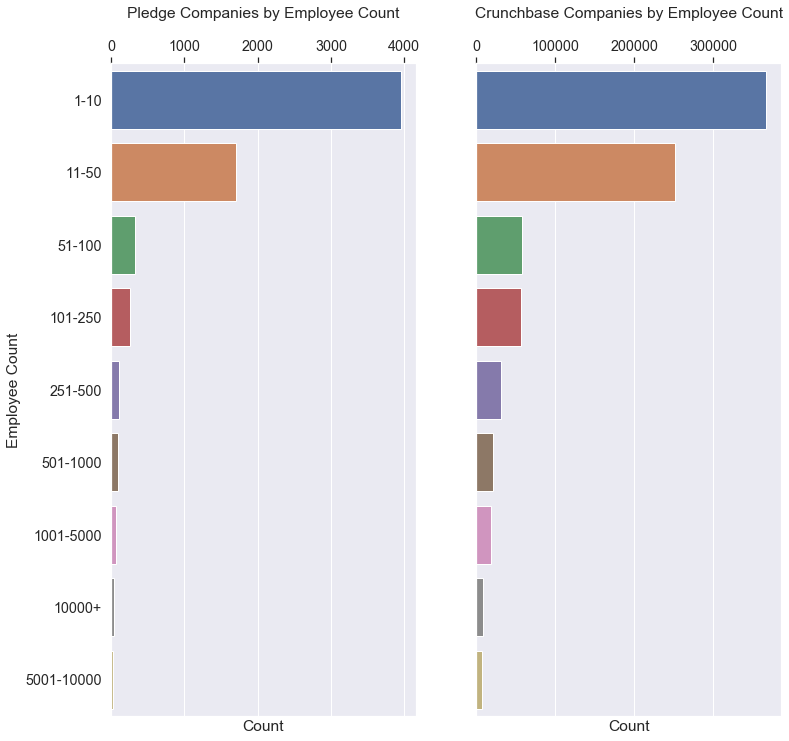

In [447]:

# Exclude rows that have NaN employee_count
pledge1_employee = pledge1[~pledge1['employee_count'].isna()]
df_employee = df[~df['employee_count'].isna()]

# Create count column to sum over
df_employee['count'] = 1

# Groupby 
pledge1_employee = pledge1_employee.groupby(['employee_count'])['p1_tag'].sum().sort_values(ascending=False).reset_index()
df_employee = df_employee.groupby(['employee_count'])['count'].sum().sort_values(ascending=False).reset_index()

# Barplots
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 12), sharey=True)
sns.barplot(x='p1_tag', y='employee_count', data=pledge1_employee, orient='h', ax=ax[0])
sns.barplot(x='count', y='employee_count', data=df_employee, orient='h', ax=ax[1])

# Labels
ax[0].set_title('Pledge Companies by Employee Count\n')
ax[0].xaxis.set_ticks_position('top')
ax[0].set_xlabel('Count')
ax[0].set_ylabel('Employee Count')
ax[1].set_title('Crunchbase Companies by Employee Count\n')
ax[1].xaxis.set_ticks_position('top')
ax[1].set_xlabel('Count')
ax[1].set_ylabel('')

# Plot
plt.show()

del df_employee, pledge1_employee

## How do the Pledge 1% and Crunchbase organizations vary by country_code?

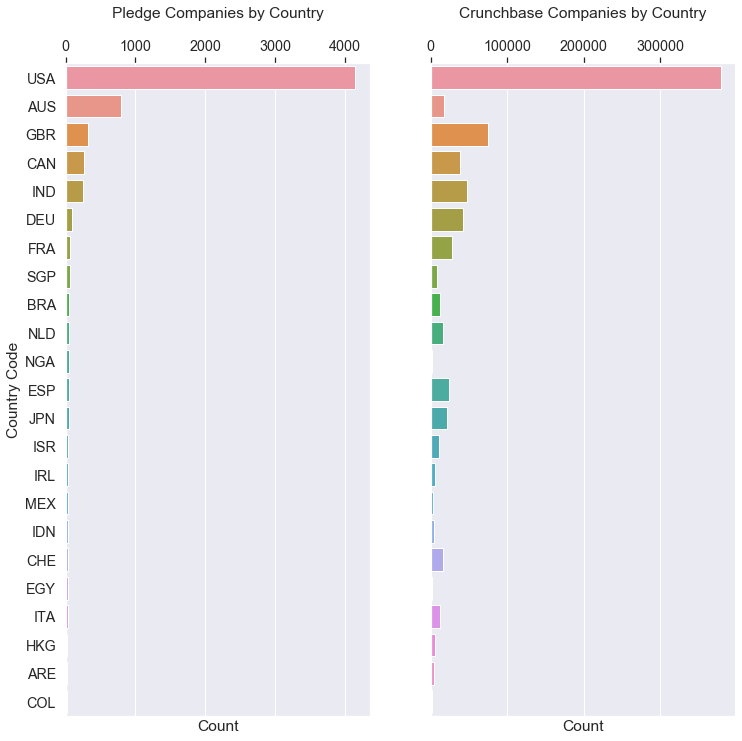

In [448]:
# Create plotting dataframes of top 25 countries
pledge1_countries = pledge1[~pledge1['country_code'].isna()] 
pledge1_countries = pledge1_countries.groupby(['country_code'])['p1_tag'].sum().sort_values(ascending=False).reset_index()
pledge1_countries = pledge1_countries[pledge1_countries['p1_tag'] >= 25]
top_25_p1_countries = pledge1_countries['country_code'].to_list()
df_countries = df[~df['country_code'].isna()]
df_countries['count'] = 1
df_countries = df_countries.groupby(['country_code'])['count'].sum().sort_values(ascending=False).reset_index()
df_countries = df_countries.set_index('country_code').reindex(top_25_p1_countries).reset_index()

# Barplots
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 12), sharey=True)
sns.barplot(x='p1_tag', y='country_code', data=pledge1_countries, orient='h', ax=ax[0])
sns.barplot(x='count', y='country_code', data=df_countries, orient='h', ax=ax[1])

# Labels
ax[0].set_title('Pledge Companies by Country\n')
ax[0].xaxis.set_ticks_position('top')
ax[0].set_ylabel('Country Code')
ax[0].set_xlabel('Count')
ax[1].set_title('Crunchbase Companies by Country\n')
ax[1].xaxis.set_ticks_position('top')
ax[1].set_xlabel('Count')
ax[1].set_ylabel('')

plt.show()

del pledge1_countries, df_countries

## Merge Data Sets (df_inv = p1 + org + investment)

In [449]:
# Merge p1 and investor dataframes on the organization uuid
df_inv = pd.merge(df.copy(), investor.copy(), how='outer',on='uuid')

# Convert Boolean to binary
df_inv['p1_tag'] = df_inv['p1_tag'].apply(lambda x: 1 if x == True else 0)
p1['p1_tag'] = 1

df_inv.head(5)

,uuid,name_x,type,rank,roles,country_code,region,status,category_groups_list,total_funding_usd,founded_on,closed_on,employee_count,primary_role,p1_tag,p1_date,name_y,investor_types
0,e1393508-30ea-8a36-3f96-dd3226033abd,Wetpaint,organization,102736.0,company,USA,New York,acquired,"Content and Publishing,Internet Services,Media...",3.975000e+07,2005-06-01,NaN,51-100,company,0,NaN,NaN,NaN
1,bf4d7b0e-b34d-2fd8-d292-6049c4f7efc7,Zoho,organization,24985.0,"investor,company",USA,California,operating,"Information Technology,Internet Services,Priva...",NaN,1996-09-15,NaN,1001-5000,company,0,NaN,Zoho,NaN
2,5f2b40b8-d1b3-d323-d81a-b7a8e89553d0,Digg,organization,9319.0,company,USA,New York,acquired,"Internet Services,Media and Entertainment",4.900000e+07,2004-10-11,NaN,51-100,company,0,NaN,NaN,NaN
3,f4d5ab44-058b-298b-ea81-380e6e9a8eec,Omidyar Network,organization,29637.0,investor,USA,California,operating,"Financial Services,Lending and Investments,Sof...",NaN,2004-01-01,NaN,101-250,investor,0,NaN,Omidyar Network,family_investment_office
4,df662812-7f97-0b43-9d3e-12f64f504fbb,Facebook,organization,222.0,"investor,company",USA,California,acquired,"Apps,Commerce and Shopping,Content and Publish...",2.335700e+09,2004-02-04,NaN,10000+,company,0,NaN,Facebook,NaN


## How do the Pledge 1% and Crunchbase companies vary by investor type?

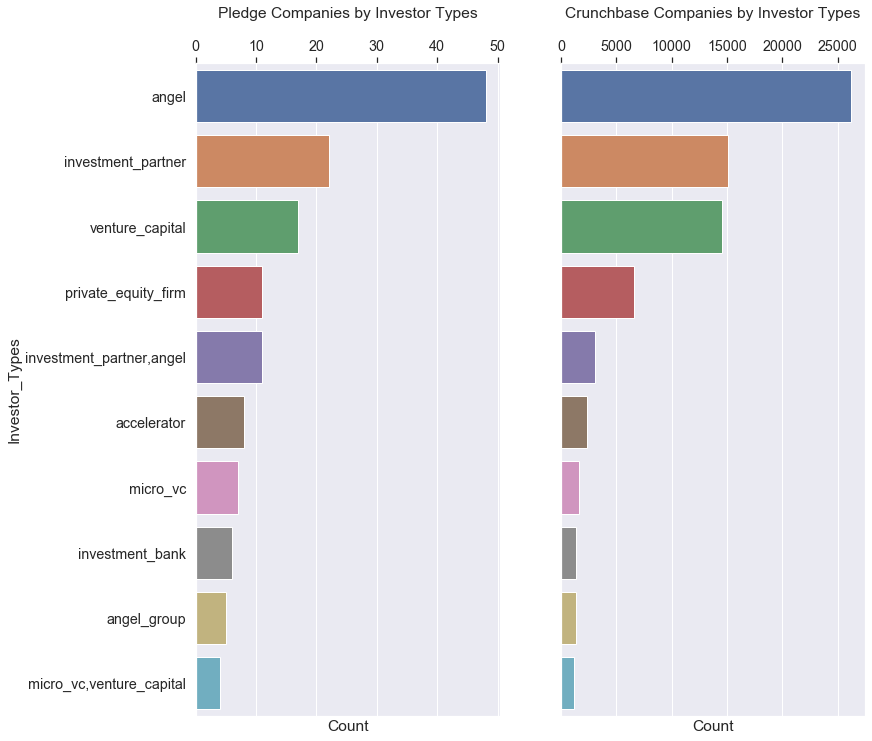

In [450]:
# Exclude rows that have NaN values
df_investor_types = df_inv[['uuid', 'name_x', 'type', 'roles', 'investor_types']]
df_investor_types = df_inv[~df_inv['name_x'].isna()]
df_investor_types = df_inv[~df_inv['type'].isna()]
df_investor_types = df_inv[~df_inv['roles'].isna()]
df_investor_types = df_inv[~df_inv['investor_types'].isna()]

pledge1_investor_types = df_investor_types[df_inv['p1_tag'] == 1].sort_values('p1_date')

# Create count column to sum over
df_investor_types['count'] = 1

# Groupby 
pledge1_investor_types = pledge1_investor_types.groupby(['investor_types'])['p1_tag'].sum().sort_values(ascending=False).reset_index()[0:10]
df_investor_types = df_investor_types.groupby(['investor_types'])['count'].sum().sort_values(ascending=False).reset_index()[0:10]

# Barplots
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 12), sharey=True)
sns.barplot(x='p1_tag', y='investor_types', data=pledge1_investor_types, orient='h', ax=ax[0])
sns.barplot(x='count', y='investor_types', data=df_investor_types, orient='h', ax=ax[1])

# Labels
ax[0].set_title('Pledge Companies by Investor Types\n')
ax[0].xaxis.set_ticks_position('top')
ax[0].set_xlabel('Count')
ax[0].set_ylabel('Investor_Types')
ax[1].set_title('Crunchbase Companies by Investor Types\n')
ax[1].xaxis.set_ticks_position('top')
ax[1].set_xlabel('Count')
ax[1].set_ylabel('')

# Plot
plt.show()

del pledge1_investor_types, df_investor_types

## Merge Data Set (df_inv = p1 + org + fund_rnds)

In [451]:
# Join df with fund_rnds dataset
df['org_uuid'] = df['uuid']
fund_rnds['funding_round_uuid'] = fund_rnds['uuid']

# Merge df with fund_rnds on org_uuid
df_fund = pd.merge(df.copy(),fund_rnds.copy(),how='outer',on='org_uuid')

# Convert Boolean to binary
df_fund['p1_tag'] = df_fund['p1_tag'].apply(lambda x: 1 if x == True else 0)
p1['p1_tag'] = 1

df_fund.head(5)

,uuid_x,name,type,rank,roles,country_code,region,status,category_groups_list,total_funding_usd,...,uuid_y,investment_type,announced_on,raised_amount_usd,post_money_valuation_usd,investor_count,lead_investor_uuids,lead_investor_count,org_name,funding_round_uuid
0,e1393508-30ea-8a36-3f96-dd3226033abd,Wetpaint,organization,102736.0,company,USA,New York,acquired,"Content and Publishing,Internet Services,Media...",39750000.0,...,06c1218c-7e15-a01d-c277-42f07a2b3743,series_a,2005-10-01,5250000.0,NaN,2.0,"42d516ee-bf29-387b-6946-3f2607aac85b,7ca12f7a-...",2.0,Wetpaint,06c1218c-7e15-a01d-c277-42f07a2b3743
1,e1393508-30ea-8a36-3f96-dd3226033abd,Wetpaint,organization,102736.0,company,USA,New York,acquired,"Content and Publishing,Internet Services,Media...",39750000.0,...,9bb86e43-5e93-74d1-d52c-39e9cecfb648,series_b,2007-01-01,9500000.0,NaN,3.0,b08efc27-da40-505a-6f9d-c9e14247bf36,1.0,Wetpaint,9bb86e43-5e93-74d1-d52c-39e9cecfb648
2,e1393508-30ea-8a36-3f96-dd3226033abd,Wetpaint,organization,102736.0,company,USA,New York,acquired,"Content and Publishing,Internet Services,Media...",39750000.0,...,6e02dcbf-49e1-97f4-8ad7-ca6888a4982f,series_c,2008-05-19,25000000.0,NaN,4.0,65ee9a90-bb84-32ca-bb0c-59020fae9a20,1.0,Wetpaint,6e02dcbf-49e1-97f4-8ad7-ca6888a4982f
3,bf4d7b0e-b34d-2fd8-d292-6049c4f7efc7,Zoho,organization,24985.0,"investor,company",USA,California,operating,"Information Technology,Internet Services,Priva...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5f2b40b8-d1b3-d323-d81a-b7a8e89553d0,Digg,organization,9319.0,company,USA,New York,acquired,"Internet Services,Media and Entertainment",49000000.0,...,fac3a91a-8145-d98c-8dc2-302afc7de82a,series_b,2006-12-01,8500000.0,NaN,3.0,"e2006571-6b7a-e477-002a-f7014f48a7e3,f4d5ab44-...",2.0,Digg,fac3a91a-8145-d98c-8dc2-302afc7de82a


In [452]:
# Exclude NAN values
df_invest_type = df_fund[~df_fund['uuid_x'].isna()].sort_values('p1_date')
df_invest_type = df_fund[~df_fund['name'].isna()]
df_invest_type = df_fund[~df_fund['total_funding_usd'].isna()]
df_invest_type = df_fund[~df_fund['investment_type'].isna()]
df_invest_type = df_fund[~df_fund['raised_amount_usd'].isna()]
df_invest_type = df_fund[~df_fund['investor_count'].isna()]
df_invest_type.head(5)

,uuid_x,name,type,rank,roles,country_code,region,status,category_groups_list,total_funding_usd,...,uuid_y,investment_type,announced_on,raised_amount_usd,post_money_valuation_usd,investor_count,lead_investor_uuids,lead_investor_count,org_name,funding_round_uuid
0,e1393508-30ea-8a36-3f96-dd3226033abd,Wetpaint,organization,102736.0,company,USA,New York,acquired,"Content and Publishing,Internet Services,Media...",39750000.0,...,06c1218c-7e15-a01d-c277-42f07a2b3743,series_a,2005-10-01,5250000.0,NaN,2.0,"42d516ee-bf29-387b-6946-3f2607aac85b,7ca12f7a-...",2.0,Wetpaint,06c1218c-7e15-a01d-c277-42f07a2b3743
1,e1393508-30ea-8a36-3f96-dd3226033abd,Wetpaint,organization,102736.0,company,USA,New York,acquired,"Content and Publishing,Internet Services,Media...",39750000.0,...,9bb86e43-5e93-74d1-d52c-39e9cecfb648,series_b,2007-01-01,9500000.0,NaN,3.0,b08efc27-da40-505a-6f9d-c9e14247bf36,1.0,Wetpaint,9bb86e43-5e93-74d1-d52c-39e9cecfb648
2,e1393508-30ea-8a36-3f96-dd3226033abd,Wetpaint,organization,102736.0,company,USA,New York,acquired,"Content and Publishing,Internet Services,Media...",39750000.0,...,6e02dcbf-49e1-97f4-8ad7-ca6888a4982f,series_c,2008-05-19,25000000.0,NaN,4.0,65ee9a90-bb84-32ca-bb0c-59020fae9a20,1.0,Wetpaint,6e02dcbf-49e1-97f4-8ad7-ca6888a4982f
4,5f2b40b8-d1b3-d323-d81a-b7a8e89553d0,Digg,organization,9319.0,company,USA,New York,acquired,"Internet Services,Media and Entertainment",49000000.0,...,fac3a91a-8145-d98c-8dc2-302afc7de82a,series_b,2006-12-01,8500000.0,NaN,3.0,"e2006571-6b7a-e477-002a-f7014f48a7e3,f4d5ab44-...",2.0,Digg,fac3a91a-8145-d98c-8dc2-302afc7de82a
5,5f2b40b8-d1b3-d323-d81a-b7a8e89553d0,Digg,organization,9319.0,company,USA,New York,acquired,"Internet Services,Media and Entertainment",49000000.0,...,44dc7666-15a2-9f51-4a7a-d7015f612185,series_a,2005-10-28,2800000.0,NaN,7.0,NaN,0.0,Digg,44dc7666-15a2-9f51-4a7a-d7015f612185


## How do Pledge 1% and Crunchbase companies compare by funding round?

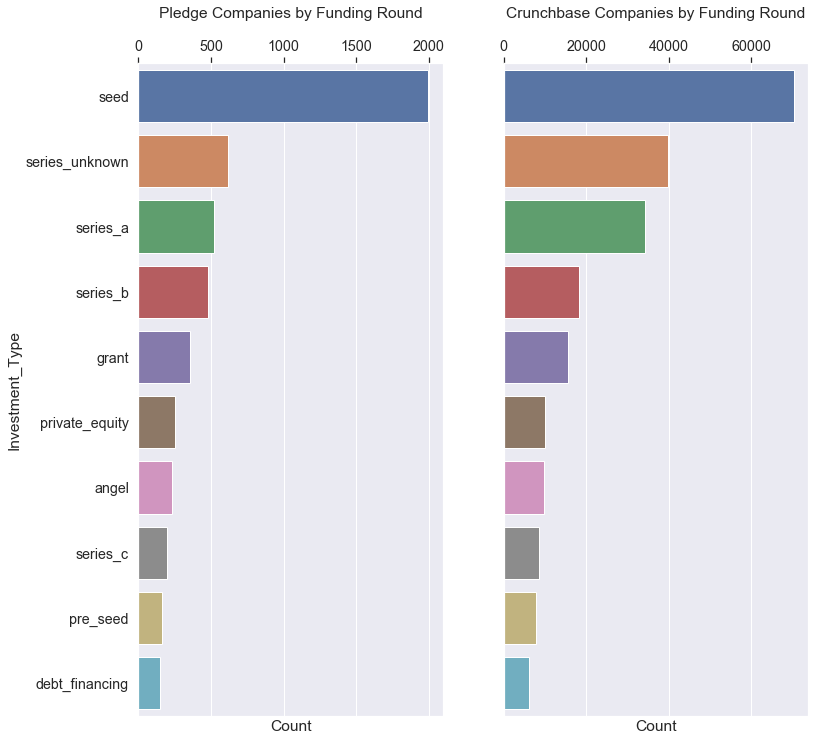

In [453]:
# Filter Pledge 1% Companies
pledge1_invest_type = df_invest_type[df_fund['p1_tag'] == 1].sort_values('p1_date')

# Create count column to sum over
df_invest_type['count'] = 1

# Groupby 
pledge1_invest_type = pledge1_invest_type.groupby(['investment_type'])['p1_tag'].sum().sort_values(ascending=False).reset_index()[0:10]
df_invest_type = df_invest_type.groupby(['investment_type'])['count'].sum().sort_values(ascending=False).reset_index()[0:10]

# Barplots
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 12), sharey=True)
sns.barplot(x='p1_tag', y='investment_type', data=pledge1_invest_type, orient='h', ax=ax[0])
sns.barplot(x='count', y='investment_type', data=df_invest_type, orient='h', ax=ax[1])

# Labels
ax[0].set_title('Pledge Companies by Funding Round\n')
ax[0].xaxis.set_ticks_position('top')
ax[0].set_xlabel('Count')
ax[0].set_ylabel('Investment_Type')
ax[1].set_title('Crunchbase Companies by Funding Round\n')
ax[1].xaxis.set_ticks_position('top')
ax[1].set_xlabel('Count')
ax[1].set_ylabel('')

# Plot
plt.show()

del pledge1_invest_type, df_invest_type

In [454]:
# Exclude NAN values
df_num_inv = df_fund[~df_fund['uuid_x'].isna()].sort_values('p1_date')
df_num_inv = df_fund[~df_fund['name'].isna()]
df_num_inv = df_fund[~df_fund['total_funding_usd'].isna()]
df_num_inv = df_fund[~df_fund['investment_type'].isna()]
df_num_inv = df_fund[~df_fund['raised_amount_usd'].isna()]
df_num_inv = df_fund[~df_fund['investor_count'].isna()]
df_num_inv.head(5)

,uuid_x,name,type,rank,roles,country_code,region,status,category_groups_list,total_funding_usd,...,uuid_y,investment_type,announced_on,raised_amount_usd,post_money_valuation_usd,investor_count,lead_investor_uuids,lead_investor_count,org_name,funding_round_uuid
0,e1393508-30ea-8a36-3f96-dd3226033abd,Wetpaint,organization,102736.0,company,USA,New York,acquired,"Content and Publishing,Internet Services,Media...",39750000.0,...,06c1218c-7e15-a01d-c277-42f07a2b3743,series_a,2005-10-01,5250000.0,NaN,2.0,"42d516ee-bf29-387b-6946-3f2607aac85b,7ca12f7a-...",2.0,Wetpaint,06c1218c-7e15-a01d-c277-42f07a2b3743
1,e1393508-30ea-8a36-3f96-dd3226033abd,Wetpaint,organization,102736.0,company,USA,New York,acquired,"Content and Publishing,Internet Services,Media...",39750000.0,...,9bb86e43-5e93-74d1-d52c-39e9cecfb648,series_b,2007-01-01,9500000.0,NaN,3.0,b08efc27-da40-505a-6f9d-c9e14247bf36,1.0,Wetpaint,9bb86e43-5e93-74d1-d52c-39e9cecfb648
2,e1393508-30ea-8a36-3f96-dd3226033abd,Wetpaint,organization,102736.0,company,USA,New York,acquired,"Content and Publishing,Internet Services,Media...",39750000.0,...,6e02dcbf-49e1-97f4-8ad7-ca6888a4982f,series_c,2008-05-19,25000000.0,NaN,4.0,65ee9a90-bb84-32ca-bb0c-59020fae9a20,1.0,Wetpaint,6e02dcbf-49e1-97f4-8ad7-ca6888a4982f
4,5f2b40b8-d1b3-d323-d81a-b7a8e89553d0,Digg,organization,9319.0,company,USA,New York,acquired,"Internet Services,Media and Entertainment",49000000.0,...,fac3a91a-8145-d98c-8dc2-302afc7de82a,series_b,2006-12-01,8500000.0,NaN,3.0,"e2006571-6b7a-e477-002a-f7014f48a7e3,f4d5ab44-...",2.0,Digg,fac3a91a-8145-d98c-8dc2-302afc7de82a
5,5f2b40b8-d1b3-d323-d81a-b7a8e89553d0,Digg,organization,9319.0,company,USA,New York,acquired,"Internet Services,Media and Entertainment",49000000.0,...,44dc7666-15a2-9f51-4a7a-d7015f612185,series_a,2005-10-28,2800000.0,NaN,7.0,NaN,0.0,Digg,44dc7666-15a2-9f51-4a7a-d7015f612185


## How do Pledge 1% and Crunchbase companies compare by funding round?

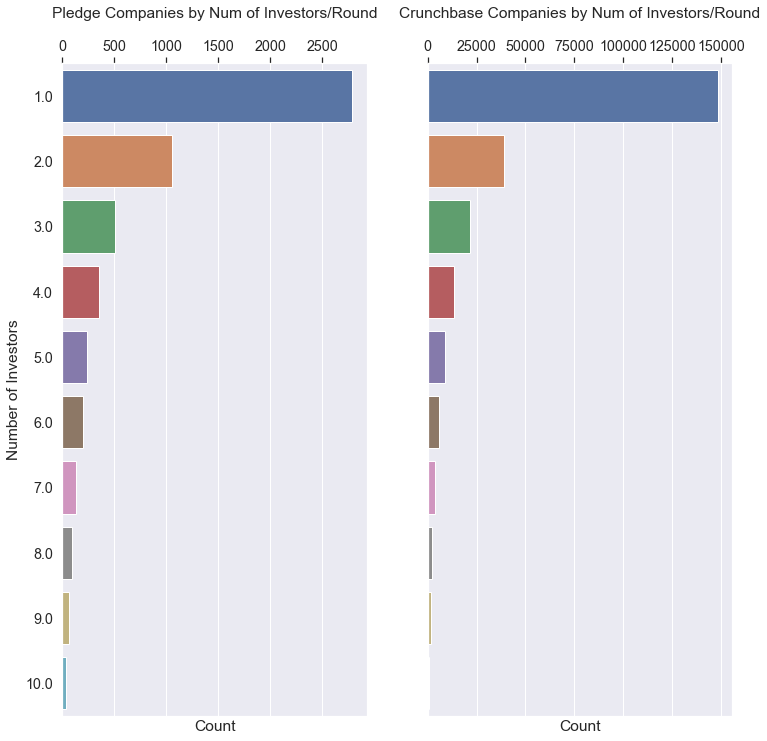

In [455]:
# Filter Pledge 1% Companies
pledge1_num_inv = df_num_inv[df_fund['p1_tag'] == 1].sort_values('p1_date')

# Create count column to sum over
df_num_inv['count'] = 1

# Groupby 
pledge1_num_inv = pledge1_num_inv.groupby(['investor_count'])['p1_tag'].sum().sort_values(ascending=False).reset_index()[0:10]
df_num_inv = df_num_inv.groupby(['investor_count'])['count'].sum().sort_values(ascending=False).reset_index()[0:10]

# Barplots
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 12), sharey=True)
sns.barplot(x='p1_tag', y='investor_count', data=pledge1_num_inv, orient='h', ax=ax[0])
sns.barplot(x='count', y='investor_count', data=df_num_inv, orient='h', ax=ax[1])

# Labels
ax[0].set_title('Pledge Companies by Num of Investors/Round\n')
ax[0].xaxis.set_ticks_position('top')
ax[0].set_xlabel('Count')
ax[0].set_ylabel('Number of Investors')
ax[1].set_title('Crunchbase Companies by Num of Investors/Round\n')
ax[1].xaxis.set_ticks_position('top')
ax[1].set_xlabel('Count')
ax[1].set_ylabel('')

# Plot
plt.show()

del pledge1_num_inv, df_num_inv

In [456]:
## Top investors
# combine org with p1 dataset on uuid
df_org = pd.merge(org.copy(),p1.copy(),how='outer',on='uuid')
print("Records in org dataframe",df_org.shape)

# typecast p1_tag to boolean(0 or 1)
df_org['p1_tag'] = df_org['p1_tag'].apply(lambda x: 1 if x == True else 0)
df_org['employee_count'] = df_org['employee_count'].apply(lambda x: np.NaN if x == 'unknown' else x)
df_org = df_org[['uuid','name','rank','status','p1_date','total_funding_usd','p1_tag']]

# join df_org with fund_rnds dataset
df_org['org_uuid'] = df_org['uuid']
fund_rnds['funding_round_uuid'] = fund_rnds['uuid']

# merge df_org with fund_rnds on org_uuid
df_org = pd.merge(df_org.copy(),fund_rnds.copy(),how='outer',on='org_uuid')

# exclude NAN values
df_org = df_org[~df_org['org_uuid'].isna()].sort_values('p1_date')

# reduce memory
df_org = reduce_mem_usage(df_org)

# merge df_org with invest dataset on funding_round_uuid
df_org = pd.merge(invest.copy(),df_org.copy(),how='outer',on='funding_round_uuid')
df_org = reduce_mem_usage(df_org)

# filter the records that do not have a matching funding_round_uuid
df_org = df_org[~df_org['funding_round_uuid'].isna()].sort_values('p1_date')

# Filter for only pledge1 companies
df_org = reduce_mem_usage(df_org)
df_org_p1 = df_org[df_org['p1_tag'] == 1].sort_values('p1_date')
print("Records in df_org dataframe(only p1 data)",df_org_p1.shape)

df_org.head()

Records in org dataframe (1131315, 16)
Mem. usage decreased to 144.12 Mb (23.0% reduction)
Mem. usage decreased to 376.02 Mb (0.0% reduction)
Mem. usage decreased to 91.72 Mb (0.0% reduction)
Records in df_org dataframe(only p1 data) (16206, 23)


,uuid,funding_round_uuid,investor_uuid,investor_name,investor_type,is_lead_investor,uuid_x,name,rank,status,...,org_uuid,uuid_y,investment_type,announced_on,raised_amount_usd,post_money_valuation_usd,investor_count,lead_investor_uuids,lead_investor_count,org_name
2416469,NaN,2e2cf6f6-fde1-4e28-b835-e3b0781fc7c8,NaN,NaN,NaN,NaN,2dc8a850-eb7c-483f-fb17-bc287abd1944,Conservation Labs,18343.0,operating,...,2dc8a850-eb7c-483f-fb17-bc287abd1944,2e2cf6f6-fde1-4e28-b835-e3b0781fc7c8,debt_financing,2020-04-03,725000.0,NaN,NaN,NaN,0.0,Conservation Labs
222847,904be835-f0cb-a639-364d-50238f8f3410,0ba508f1-612c-ffdf-0764-3c809cf6faff,39041e62-6b24-ae8d-1347-4cea947e832c,SOSV,organization,False,0dbaaa65-d37b-ea29-03cd-3526d59405e9,Bartesian,87715.0,operating,...,0dbaaa65-d37b-ea29-03cd-3526d59405e9,0ba508f1-612c-ffdf-0764-3c809cf6faff,series_unknown,2016-10-13,NaN,NaN,3.0,ffaa6c5f-c4e0-f95b-4d62-7f14e8becdf7,1.0,Bartesian
222846,c0187ffd-0e00-9f08-10f8-82566a29d023,0ba508f1-612c-ffdf-0764-3c809cf6faff,ffaa6c5f-c4e0-f95b-4d62-7f14e8becdf7,Beam Suntory,organization,True,0dbaaa65-d37b-ea29-03cd-3526d59405e9,Bartesian,87715.0,operating,...,0dbaaa65-d37b-ea29-03cd-3526d59405e9,0ba508f1-612c-ffdf-0764-3c809cf6faff,series_unknown,2016-10-13,NaN,NaN,3.0,ffaa6c5f-c4e0-f95b-4d62-7f14e8becdf7,1.0,Bartesian
2410505,52579962-5ce2-4c8d-af80-76e12942018a,d8ff8caf-6df4-4cb5-9eed-331431acf032,5b28f67a-8fd1-4f61-6fde-c5d92af09440,Ontario Centres of Excellence,organization,NaN,0dbaaa65-d37b-ea29-03cd-3526d59405e9,Bartesian,87715.0,operating,...,0dbaaa65-d37b-ea29-03cd-3526d59405e9,d8ff8caf-6df4-4cb5-9eed-331431acf032,grant,2015-12-10,125000.0,NaN,1.0,NaN,0.0,Bartesian
2408832,20a3021a-a0db-4219-84a3-550293ec443b,460eaf94-94ab-4e22-932c-2f9cb8edf9a9,5b28f67a-8fd1-4f61-6fde-c5d92af09440,Ontario Centres of Excellence,organization,NaN,0dbaaa65-d37b-ea29-03cd-3526d59405e9,Bartesian,87715.0,operating,...,0dbaaa65-d37b-ea29-03cd-3526d59405e9,460eaf94-94ab-4e22-932c-2f9cb8edf9a9,seed,2016-01-01,NaN,NaN,1.0,NaN,0.0,Bartesian


In [457]:
# create p1 dataset grouped on investor_name by aggregating raised_amount_usd
df_20 = df_org.groupby('investor_name',as_index=False).agg({"raised_amount_usd":"sum"}).\
sort_values('raised_amount_usd',ascending=False)[0:20]
df_20.head()

,investor_name,raised_amount_usd
38770,Kohlberg Kravis Roberts,1.441427e+11
62598,Silver Lake,1.422840e+11
32993,JP Morgan Chase,1.419969e+11
46601,Morgan Stanley,1.219636e+11
18620,Deutsche Bank,1.164533e+11


In [458]:
# create p1 dataset grouped on investor_name by aggregating raised_amount_usd
df_p1_20 = df_org_p1.groupby('investor_name',as_index=False).agg({"raised_amount_usd":"sum"}).\
sort_values('raised_amount_usd',ascending=False)[0:20]
df_p1_20.head()

,investor_name,raised_amount_usd
2178,HNA Group,6.500000e+09
4399,Salesforce Ventures,4.832508e+09
2339,ICONIQ Capital,4.546400e+09
4656,SoftBank Vision Fund,4.009700e+09
137,Accel,3.804049e+09


In [459]:
## Top people of P1 companies
# combine org with p1 dataset on uuid
p1_org = pd.merge(org.copy(),p1.copy(),how='outer',on='uuid')
print("Records in org dataframe",p1_org.shape)

# typecast p1_tag to boolean(0 or 1)
p1_org['p1_tag'] = p1_org['p1_tag'].apply(lambda x: 1 if x == True else 0)
p1_org['employee_count'] = p1_org['employee_count'].apply(lambda x: np.NaN if x == 'unknown' else x)
p1_org = p1_org[['uuid','name','rank','status','p1_date','total_funding_usd','p1_tag']]

p1_org['featured_job_organization_uuid'] = p1_org['uuid']
df_ppl_org = pd.merge(ppl.copy(),p1_org.copy(),how='outer',on='featured_job_organization_uuid')
df_ppl_org['person_name'] = df_ppl_org['name_x']
df_ppl_org['org_name'] = df_ppl_org['name_y']
df_ppl_org = df_ppl_org[['person_name','first_name','last_name','gender','city','country_code','featured_job_organization_uuid','featured_job_title',
                        'featured_job_organization_name','p1_tag','p1_date']]

# join df_org with fund_rnds dataset
df_ppl_org['org_uuid'] = df_ppl_org['featured_job_organization_uuid']

# merge df_org with fund_rnds on org_uuid
df_ppl_org = pd.merge(df_ppl_org.copy(),fund_rnds.copy(),how='outer',on='org_uuid')

# exclude NAN values
df_ppl_org_fnd = df_ppl_org[['org_uuid','person_name','first_name','last_name','gender','city','country_code','featured_job_organization_uuid','featured_job_title',
                        'featured_job_organization_name','p1_tag','p1_date','raised_amount_usd']]
df_ppl_org_fnd = df_ppl_org_fnd[~df_ppl_org_fnd['org_uuid'].isna()].sort_values('p1_date')
df_ppl_org_fnd = df_ppl_org_fnd[~df_ppl_org_fnd['raised_amount_usd'].isna()]
df_ppl_org_fnd = df_ppl_org_fnd[~df_ppl_org_fnd['person_name'].isna()]

# Filter for only pledge1 companies
df_ppl_org_fnd = reduce_mem_usage(df_ppl_org_fnd)
df_ppl_org_fnd_p1 = df_ppl_org_fnd[df_ppl_org_fnd['p1_tag'] == 1].sort_values('p1_date')
print("Records in df_org dataframe(only p1 data)",p1_org_p1.shape)

# reduce memory
df_ppl_org_fnd = reduce_mem_usage(df_ppl_org_fnd)

df_ppl_org_fnd.head()

Records in org dataframe (1131315, 16)
Mem. usage decreased to 74.35 Mb (8.9% reduction)
Records in df_org dataframe(only p1 data) (7822, 8)
Mem. usage decreased to 74.35 Mb (0.0% reduction)


,org_uuid,person_name,first_name,last_name,gender,city,country_code,featured_job_organization_uuid,featured_job_title,featured_job_organization_name,p1_tag,p1_date,raised_amount_usd
1632104,be222299-0936-3d86-a1f7-7c8078a771f6,Thierry Meimoun,Thierry,Meimoun,male,Gisors,FRA,be222299-0936-3d86-a1f7-7c8078a771f6,Founder and CEO,Paytweak,1.0,1/1/2018,754038.0
1632105,be222299-0936-3d86-a1f7-7c8078a771f6,Thierry Meimoun,Thierry,Meimoun,male,Gisors,FRA,be222299-0936-3d86-a1f7-7c8078a771f6,Founder and CEO,Paytweak,1.0,1/1/2018,1162985.0
1433297,0dbaaa65-d37b-ea29-03cd-3526d59405e9,Bryan Freddie,Bryan,Freddie,male,Waterloo,CAN,0dbaaa65-d37b-ea29-03cd-3526d59405e9,NaN,Bartesian,1.0,1/1/2018,125000.0
1433305,0dbaaa65-d37b-ea29-03cd-3526d59405e9,Ryan Close,Ryan,Close,male,Chicago,USA,0dbaaa65-d37b-ea29-03cd-3526d59405e9,Co-Founder,Bartesian,1.0,1/1/2018,125000.0
1678011,2dc8a850-eb7c-483f-fb17-bc287abd1944,Mark Kovscek,Mark,Kovscek,male,Pittsburgh,USA,2dc8a850-eb7c-483f-fb17-bc287abd1944,Founder and CEO,Conservation Labs,1.0,1/1/2018,20000.0


In [460]:
# create Crunchbase dataset grouped on investor_name by aggregating raised_amount_usd
df_ppl_20 = df_ppl_org_fnd.groupby('person_name',as_index=False).agg({"raised_amount_usd":"sum"}).\
sort_values('raised_amount_usd',ascending=False)[0:20]

# create p1 dataset grouped on investor_name by aggregating raised_amount_usd
df_p1_ppl_20 = df_ppl_org_fnd_p1.groupby('person_name',as_index=False).agg({"raised_amount_usd":"sum"}).\
sort_values('raised_amount_usd',ascending=False)[0:20]

In [461]:
# categorize amounts in billion using plots

def reformat_large_tick_values(tick_val, pos):
    """
    Turns large tick values (in the billions, millions and thousands) such as 4500 into 4.5K and also appropriately turns 4000 into 4K (no zero after the decimal).
    """
    if tick_val >= 1000000000:
        val = round(tick_val/1000000000, 1)
        new_tick_format = '{:}B'.format(val)
    elif tick_val >= 1000000:
        val = round(tick_val/1000000, 1)
        new_tick_format = '{:}M'.format(val)
    elif tick_val >= 1000:
        val = round(tick_val/1000, 1)
        new_tick_format = '{:}K'.format(val)
    elif tick_val < 1000:
        new_tick_format = round(tick_val, 1)
    else:
        new_tick_format = tick_val

    # make new_tick_format into a string value
    new_tick_format = str(new_tick_format)
    
    # code below will keep 4.5M as is but change values such as 4.0M to 4M since that zero after the decimal isn't needed
    index_of_decimal = new_tick_format.find(".")
    
    if index_of_decimal != -1:
        value_after_decimal = new_tick_format[index_of_decimal+1]
        if value_after_decimal == "0":
            # remove the 0 after the decimal point since it's not needed
            new_tick_format = new_tick_format[0:index_of_decimal] + new_tick_format[index_of_decimal+2:]
            
    return new_tick_format

## How large is the overlap between Pledge 1% and Crunchbase top investors?

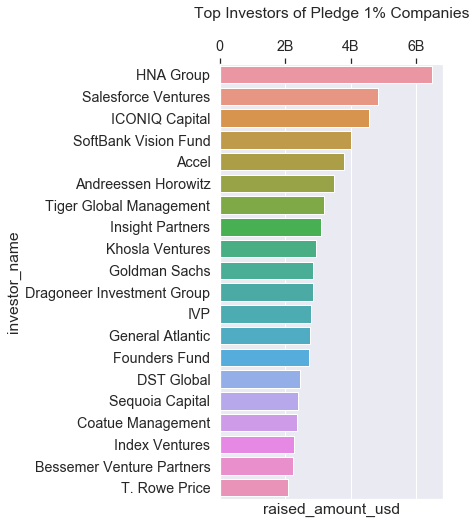

In [462]:
_, ax = plt.subplots(figsize=(4,8), sharey=True)

# p1 investors plot
ax.ticklabel_format(useOffset=False, style='plain')

ax.xaxis.set_major_formatter(ticker.FuncFormatter(reformat_large_tick_values))
ax.set_title('Top Investors of Pledge 1% Companies\n')
ax.xaxis.set_ticks_position("top")
sns.barplot(x='raised_amount_usd', y='investor_name', data=df_p1_20, orient='h', ax=ax)

#_.savefig("Investor_Report.pdf", bbox_inches='tight')

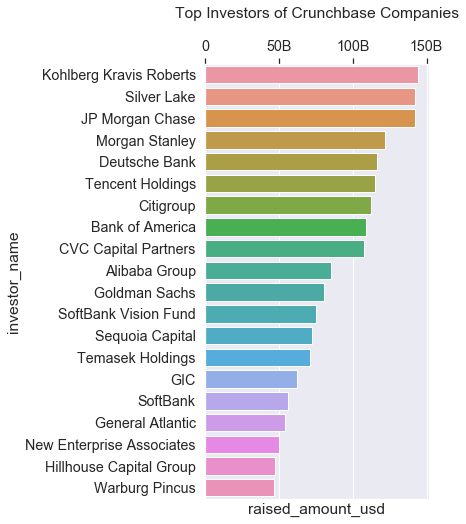

In [463]:
_, ax = plt.subplots(figsize=(4,8), sharey=True)

# p1 investors plot
ax.ticklabel_format(useOffset=False, style='plain')

ax.xaxis.set_major_formatter(ticker.FuncFormatter(reformat_large_tick_values))
ax.set_title('Top Investors of Crunchbase Companies\n')
ax.xaxis.set_ticks_position("top")
sns.barplot(x='raised_amount_usd', y='investor_name', data=df_20, orient='h', ax=ax)

#_.savefig("Investor_Report.pdf", bbox_inches='tight')

## How large is the overlap between Pledge 1% and Crunchbase top people?

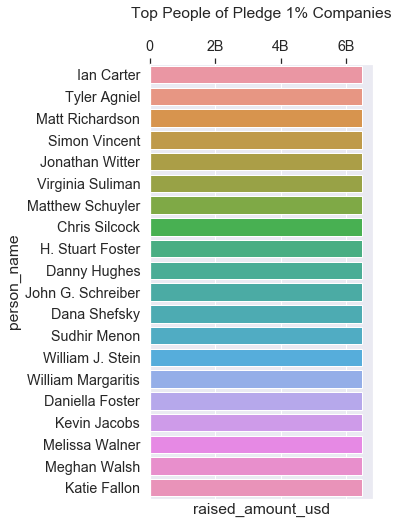

In [464]:
_, ax = plt.subplots(figsize=(4,8), sharey=True)

# p1 investors plot
ax.xaxis.set_major_formatter(ticker.FuncFormatter(reformat_large_tick_values))
ax.set_title('Top People of Pledge 1% Companies\n')
ax.xaxis.set_ticks_position("top")
fig2 = sns.barplot(x='raised_amount_usd', y='person_name', data=df_p1_ppl_20, orient='h', ax=ax)

#_.savefig("People_Report.pdf", bbox_inches='tight')

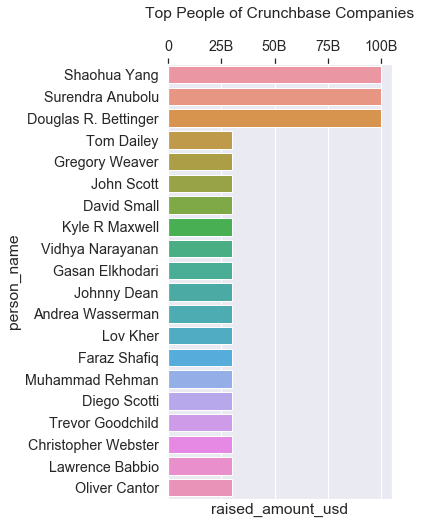

In [465]:
_, ax = plt.subplots(figsize=(4,8), sharey=True)

# Crunchbase investors plot
ax.xaxis.set_major_formatter(ticker.FuncFormatter(reformat_large_tick_values))
ax.set_title('Top People of Crunchbase Companies\n')
ax.xaxis.set_ticks_position("top")
fig2 = sns.barplot(x='raised_amount_usd', y='person_name', data=df_ppl_20, orient='h', ax=ax)

#_.savefig("People_Report.pdf", bbox_inches='tight')